# Scenario

The Look is a fashion retail company with a diverse range of apparel. It is an e-commerce store operating mainly through an online platform. Over the years, The Look has accumulated a substantial amount of sales data, customer information, and product details. The company wants me to analyze the data and gain actionable insights that will improve their business performance.

Note that the scenario is imaginary, and the dataset used contains synthetic data that is publicly available via the **Bigquery Public Dataset** project.

# Goal Specification

The primary objective of this project is to conduct a product performance analysis for The Look store by evaluating their sales performances across different product categories, brands, and individual products. This will enable us to identify top-performing and underperforming products for informing product optimization strategies.

The expected deliverables are:
* Overview of the dataset including an entity relationship diagram.
* SQL queries and outputs used for data extraction, cleaning, and analysis.
* Dashboard visualization of key findings and performance insights.

# Project Setup
The project is set up using Kaggle's Bigquery integration. We will fetch the data for **The Look e-commerce** store from the **Bigquery Public Data** project using the Bigquery API. I have also created a project named **The Look Product Analysis** to store data tables where required.

In [1]:
from google.cloud import bigquery

# Create a Client object
client = bigquery.Client(project = "the-look-product-analysis")

# Construct a reference to the "thelook_ecommerce" dataset
dataset_ref = client.dataset("thelook_ecommerce", project = "bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

It is quite tedious to rewrite the API codes everytime we have to run a query. So, I have written a helper function to enable running queries with ease inside the notebook.

In [2]:
def run(query):
    
    # Set up the query
    safe_config = bigquery.QueryJobConfig(maximum_bytes_billed = 10 ** 10)
    query_job = client.query(query, job_config = safe_config)

    # API request - run the query, and return a pandas DataFrame
    results = query_job.to_dataframe()

    # return results
    return(results)

# Preparation

To get an overview of the dataset, let us check the table names, the number of rows in each table, the data fields in each table and their corresponding data types. We will also generate a relationship diagram to get a visual idea of the tables and the relationships between them.

Note that instead of querying each table separately, I have opted to use a for loop where applicable.

## Table Names

We can use SQL to get the dataset matadata from Bigquery by querying the `INFORMATION_SCHEMA`.

In [3]:
query = """
SELECT table_name
FROM `bigquery-public-data.thelook_ecommerce.INFORMATION_SCHEMA.TABLES`
"""
table_names = run(query)
display(table_names)

,table_name
0,users
1,order_items
2,distribution_centers
3,inventory_items
4,products
5,orders
6,events


Let us create a list of table names so that we can iterate similar queries over all tables using a for loop.

In [4]:
ids = table_names["table_name"].values.tolist()

## Row Counts

We can get an approximate count of the number of rows in a Bigquery table by looking into the table stats.

In [5]:
for id in ids:
    query = f"""
    SELECT table_id, row_count
    FROM `bigquery-public-data.thelook_ecommerce.__TABLES__`
    WHERE table_id = '{id}'
    """
    display(run(query))

,table_id,row_count
0,users,100000


,table_id,row_count
0,order_items,181649


,table_id,row_count
0,distribution_centers,10


,table_id,row_count
0,inventory_items,490755


,table_id,row_count
0,products,29120


,table_id,row_count
0,orders,125305


,table_id,row_count
0,events,2426514


## Fields & Data Types

The `INFORMATION_SCHEMA` also contains information about the `COLUMNS` in a table.

In [6]:
for id in ids:
    print(id)
    query = f"""
    SELECT column_name, data_type
    FROM `bigquery-public-data.thelook_ecommerce.INFORMATION_SCHEMA.COLUMNS` 
    WHERE table_name = '{id}'
    """
    display(run(query))
    print()

users


,column_name,data_type
0,id,INT64
1,first_name,STRING
2,last_name,STRING
3,email,STRING
4,age,INT64
5,gender,STRING
6,state,STRING
7,street_address,STRING
8,postal_code,STRING
9,city,STRING



order_items


,column_name,data_type
0,id,INT64
1,order_id,INT64
2,user_id,INT64
3,product_id,INT64
4,inventory_item_id,INT64
5,status,STRING
6,created_at,TIMESTAMP
7,shipped_at,TIMESTAMP
8,delivered_at,TIMESTAMP
9,returned_at,TIMESTAMP



distribution_centers


,column_name,data_type
0,id,INT64
1,name,STRING
2,latitude,FLOAT64
3,longitude,FLOAT64



inventory_items


,column_name,data_type
0,id,INT64
1,product_id,INT64
2,created_at,TIMESTAMP
3,sold_at,TIMESTAMP
4,cost,FLOAT64
5,product_category,STRING
6,product_name,STRING
7,product_brand,STRING
8,product_retail_price,FLOAT64
9,product_department,STRING



products


,column_name,data_type
0,id,INT64
1,cost,FLOAT64
2,category,STRING
3,name,STRING
4,brand,STRING
5,retail_price,FLOAT64
6,department,STRING
7,sku,STRING
8,distribution_center_id,INT64



orders


,column_name,data_type
0,order_id,INT64
1,user_id,INT64
2,status,STRING
3,gender,STRING
4,created_at,TIMESTAMP
5,returned_at,TIMESTAMP
6,shipped_at,TIMESTAMP
7,delivered_at,TIMESTAMP
8,num_of_item,INT64



events


,column_name,data_type
0,id,INT64
1,user_id,INT64
2,sequence_number,INT64
3,session_id,STRING
4,created_at,TIMESTAMP
5,ip_address,STRING
6,city,STRING
7,state,STRING
8,postal_code,STRING
9,browser,STRING


## Relationship Diagram

I have generated an entity relationship diagram by transferring the queried data in the above section to [Quick DBD](https://www.quickdatabasediagrams.com/). It gives us a comprehensive overview of the dataset tables along with their primary keys, foreign keys and interrelations.

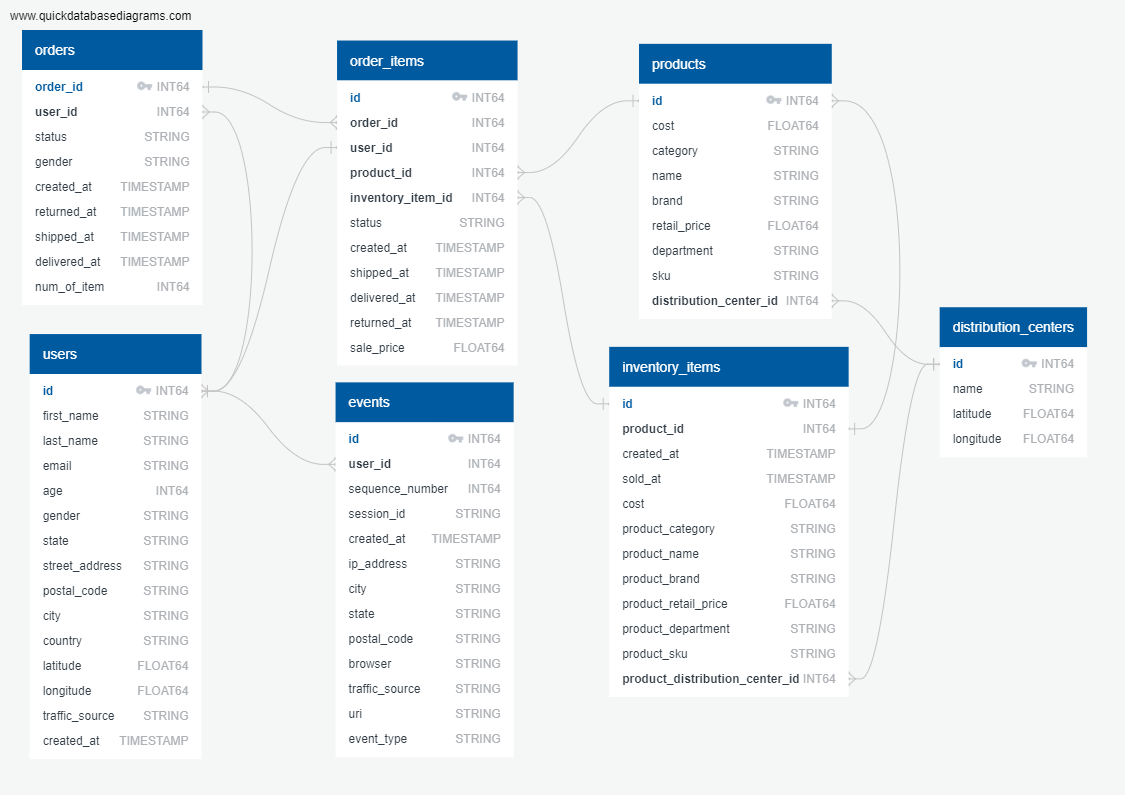

With this, we have equipped ourselves with the necessary tools to clean and analyze the data. We want to find out the top performing products of the store. For this, we will use the `products` and `order_items` tables. As there are around 29,000 products in our data, we will also consider product `category`, `brand`, and `department` for calculating the performance metrics. The idea is to calculate `profit`, `sale_volume`, and `revenue` from the information in the `order_items` table, aggregated over different groupings from the `products` table. We may also calculate the average sales prices from the `revenue` and `sale_volume` fields.

# Data Cleaning
Notice that there are several price fields in the dataset - in the tables we have selected as well as in the `inventory_items` table. We don't have enough information to determine which of them should be designated as the cost price or the sale price. The price fields are listed below:
* `sale_price` in `order_items` table
* `retail_price` in `products` table
* `cost` in `products` table
* `cost` in `inventory_items` table
* `product_retail_price` in `inventory_items` table

Let us compare these fields by viewing a random sample of the dataset.

In [7]:
query = """
SELECT 
    oi.sale_price AS sale_price_in_order_items, 
    p.retail_price AS retail_price_in_products, 
    i.product_retail_price AS retail_price_in_inventory_items,
    p.cost AS cost_in_products,
    i.cost AS cost_in_inventory_items
FROM
  `bigquery-public-data.thelook_ecommerce.products` p
JOIN
  `bigquery-public-data.thelook_ecommerce.order_items` oi ON p.id = oi.product_id
JOIN
  `bigquery-public-data.thelook_ecommerce.inventory_items` i ON p.id = i.product_id
WHERE RAND() < 0.000005
LIMIT 5
"""
display(run(query))

,sale_price_in_order_items,retail_price_in_products,retail_price_in_inventory_items,cost_in_products,cost_in_inventory_items
0,25.000000,25.000000,25.000000,15.825000,15.825000
1,24.000000,24.000000,24.000000,10.704000,10.704000
2,79.989998,79.989998,79.989998,33.755779,33.755779
3,34.990002,34.990002,34.990002,20.434161,20.434161
4,27.969999,27.969999,27.969999,13.201840,13.201840


We see that both the retail price columns and the sale_price column the same values. The cost columns also have matching values in both the fields, and the value is consistently lesser than the retail price. So, we can use any of the retail price/sale price columns as the selling price and any of the cost columns as the cost price. Here, I have opted to use:
* the `sale_price` column of the `order_items` table as the selling price
* the `cost` column of the `products` table as the cost price

The data types of the columns in both the tables are in order. We will remove duplicate rows and select only the required columns to optimize the amount of data scanned. We are going to use aggregate functions in this section, so we need not handle nulls separately. 

For analyzing product performance, we will have to join the `products` and `order_items` tables. The primary key of the new table will be the `id` column from the `order_items` table. As the join is required for all queries in the section, we will restructure the data at the this stage for efficiency. Additionally, we can also calculate the values of the key metrics, that is, `sales_volume`, `revenue` and `profit`. The cleaned tables will joined and stored in our Bigquery project The Look Product Analysis.

In [8]:
query = """
CREATE OR REPLACE TABLE `the-look-product-analysis.sales.product_performance` AS
    SELECT 
        DISTINCT(p.id) AS product_id, p.name, p.cost, p.category, p.brand, p.department, 
        oi.id AS order_item_id, oi.sale_price
    FROM `bigquery-public-data.thelook_ecommerce.products` AS p
    JOIN `bigquery-public-data.thelook_ecommerce.order_items` AS oi
    ON p.id = oi.product_id
"""

display(run(query))

""


Let us look at a slice of the table we just created.

In [9]:
query = """
SELECT * FROM `the-look-product-analysis.sales.product_performance`
"""
performance_data = run(query)
display(performance_data.head())

,product_id,name,cost,category,brand,department,order_item_id,sale_price
0,16898,Quiksilver Waterman Men's On The Rise,13.925,Tops & Tees,None,Men,59839,25.0
1,16898,Quiksilver Waterman Men's On The Rise,13.925,Tops & Tees,None,Men,63680,25.0
2,16898,Quiksilver Waterman Men's On The Rise,13.925,Tops & Tees,None,Men,138476,25.0
3,16898,Quiksilver Waterman Men's On The Rise,13.925,Tops & Tees,None,Men,39378,25.0
4,16898,Quiksilver Waterman Men's On The Rise,13.925,Tops & Tees,None,Men,180060,25.0


I have exported the cleaned data for creating a dashboard.

In [10]:
performance_data.to_csv('/kaggle/working/performance_data.csv', index=False)

# Data Analysis
First we will ask a few basic questions to gauge product performances over the entire store
* What are the top 5 products by profit and sales volume?
* What are the top 5 brands by profit and sales volume?
* What are the top 5 product categories by profit and sales volume?

For a more detailed exploration, we will analyze the product performance by ranking `profit` margins for different groupings. The `profit` will be aggregated separately over each `department`. I have chosen `profit` as the primary metric for evaluating the product ranks. We will also look at the `sale_volume`, `revenue` and `avg_sale_price` for further insight. We want to find out
* What are the top 5 products in the top 5 product categories when the profits are separately aggregated over department?
* What are the top 5 brands for each of the top 5 product categories?
* What are the top 5 brands for the top 5 product categories in each department?

First, let us check the number of distinct products, categories, and brands to get an idea of the volume of data we might be scanning or expecting as outputs. 

In [11]:
query = """
SELECT 
    COUNT(DISTINCT(product_id)) AS num_products, 
    COUNT(DISTINCT(category)) AS num_categories, 
    COUNT(DISTINCT(brand)) AS num_brands,     
FROM
    `the-look-product-analysis.sales.product_performance`
"""
run(query)

,num_products,num_categories,num_brands
0,29049,26,2754


Now, we will query the 5 best performing products in the store, first in terms of `profit` and then in terms of `sale_volume`. Since there are 29052 distinct products, it doesn't make sense to rank them all. So, we will only list the top products.

In [12]:
query = """
WITH
ranked_products AS (
    SELECT
        name,
        COUNT(order_item_id) AS sale_volume,
        ROUND(SUM(sale_price - cost)) AS profit,
        ROUND(SUM(sale_price)) AS revenue,
        RANK() 
            OVER (
                ORDER BY SUM(sale_price - cost) DESC
            ) AS profit_rank
    FROM
        `the-look-product-analysis.sales.product_performance`
    GROUP BY name
)
SELECT 
    profit_rank, name, 
    profit, sale_volume, revenue, revenue/sale_volume AS avg_sale_price
FROM ranked_products
WHERE profit_rank <= 5
ORDER BY profit_rank
"""
run(query)

,profit_rank,name,profit,sale_volume,revenue,avg_sale_price
0,1,NIKE WOMEN'S PRO COMPRESSION SPORTS BRA *Outst...,8253.0,18,16254.0,903.0
1,2,The North Face Apex Bionic Soft Shell Jacket -...,6558.0,15,13545.0,903.0
2,3,The North Face Denali Down Womens Jacket 2013,6473.0,13,11739.0,903.0
3,4,Canada Goose Women's Mystique,6315.0,15,11250.0,750.0
4,5,Canada Goose Men's The Chateau Jacket,5883.0,13,10595.0,815.0


In [13]:
query = """
WITH
ranked_products AS (
    SELECT
        name,
        COUNT(order_item_id) AS sale_volume,
        ROUND(SUM(sale_price - cost)) AS profit,
        ROUND(SUM(sale_price)) AS revenue,
        ROW_NUMBER() 
            OVER (
                ORDER BY COUNT(order_item_id) DESC
            ) AS vol_rank
    FROM
        `the-look-product-analysis.sales.product_performance`
    GROUP BY name
)
SELECT 
    vol_rank AS sale_volume_rank, name, 
    sale_volume, profit, revenue, revenue/sale_volume AS avg_sale_price
FROM ranked_products
WHERE vol_rank <= 5
ORDER BY vol_rank
"""
run(query)

,sale_volume_rank,name,sale_volume,profit,revenue,avg_sale_price
0,1,Wrangler Men's Premium Performance Cowboy Cut ...,53,1164.0,2551.0,48.132075
1,2,Thorlo Unisex Experia Running Sock,39,340.0,624.0,16.000000
2,3,Volcom Men's Vorta Slim Straight Leg Fit Jean,36,1195.0,2738.0,76.055556
3,4,True Religion Men's Ricky Straight Jean,35,4039.0,8658.0,247.371429
4,5,Wrangler Men's Rugged Wear Classic Fit Jean,33,713.0,1543.0,46.757576


Let us query the top 5 brands with the highest profits in the store and then the top 5 brands with the highest sale volumes. Again, the number of distinct brands (>2700) is quite large. So, we will only rank the top ones.

In [14]:
query = """
WITH
ranked_brands AS(
    SELECT 
        brand, 
        RANK() 
            OVER (
            ORDER BY SUM(sale_price - cost) DESC
            ) AS brand_rank,
        COUNT(order_item_id) AS sale_volume,
        ROUND(SUM(sale_price - cost)) AS profit,
        ROUND(SUM(sale_price)) AS revenue
    FROM `the-look-product-analysis.sales.product_performance`
    GROUP BY brand
)
SELECT
brand_rank AS profit_rank, brand, profit, sale_volume, revenue, revenue/sale_volume AS avg_sale_price
FROM ranked_brands
WHERE brand_rank <= 5
ORDER BY brand_rank
"""
run(query)

,profit_rank,brand,profit,sale_volume,revenue,avg_sale_price
0,1,Calvin Klein,107589.0,3212,202371.0,63.004670
1,2,Diesel,95563.0,1449,192866.0,133.102830
2,3,Carhartt,94680.0,2541,177585.0,69.887839
3,4,7 For All Mankind,88678.0,1180,185531.0,157.229661
4,5,True Religion,85359.0,904,178539.0,197.498894


In [15]:
query = """
WITH
ranked_brands AS(
    SELECT 
        brand, 
        RANK() 
            OVER (
            ORDER BY COUNT(order_item_id) DESC
            ) AS brand_rank,
        COUNT(order_item_id) AS sale_volume,
        ROUND(SUM(sale_price - cost)) AS profit,
        ROUND(SUM(sale_price)) AS revenue
    FROM `the-look-product-analysis.sales.product_performance`
    GROUP BY brand
)
SELECT brand_rank, brand, sale_volume, profit, revenue, revenue/sale_volume AS avg_sale_price
FROM ranked_brands
WHERE brand_rank <= 5
ORDER BY brand_rank
"""
run(query)

,brand_rank,brand,sale_volume,profit,revenue,avg_sale_price
0,1,Allegra K,6240,47265.0,89444.0,14.333974
1,2,Calvin Klein,3212,107589.0,202371.0,63.004670
2,3,Carhartt,2541,94680.0,177585.0,69.887839
3,4,Hanes,2002,20853.0,39904.0,19.932068
4,5,Volcom,1932,57644.0,116741.0,60.424948


We also want to figure out the top 5 product categories in the store by profit margins and sale volumes. As there are just 25 distinct categories, it is feasible to list and compare all of them.

In [16]:
query = """
WITH
ranked_categories AS(
    SELECT 
        category, 
        RANK() 
            OVER (
            ORDER BY SUM(sale_price - cost) DESC
            ) AS category_rank,
        COUNT(order_item_id) AS sale_volume,
        ROUND(SUM(sale_price - cost)) AS profit,
        ROUND(SUM(sale_price)) AS revenue
    FROM `the-look-product-analysis.sales.product_performance`
    GROUP BY category
)
SELECT category_rank, category, profit, sale_volume, revenue
FROM ranked_categories
ORDER BY category_rank
"""
run(query)

,category_rank,category,profit,sale_volume,revenue
0,1,Outerwear & Coats,743458.0,9079,1339822.0
1,2,Jeans,586497.0,12797,1263185.0
2,3,Sweaters,427989.0,10984,825445.0
3,4,Suits & Sport Coats,380764.0,5099,636158.0
4,5,Swim,316369.0,11291,643224.0
5,6,Fashion Hoodies & Sweatshirts,300753.0,11484,625854.0
6,7,Sleep & Lounge,277245.0,11063,536828.0
7,8,Shorts,263134.0,11334,527082.0
8,9,Active,260934.0,9061,449534.0
9,10,Dresses,256829.0,5550,467523.0


In [17]:
query = """
WITH
ranked_categories AS(
    SELECT 
        category, 
        RANK() 
            OVER (
            ORDER BY COUNT(order_item_id) DESC
            ) AS category_rank,
        COUNT(order_item_id) AS sale_volume,
        ROUND(SUM(sale_price - cost)) AS profit,
        ROUND(SUM(sale_price)) AS revenue
    FROM `the-look-product-analysis.sales.product_performance`
    GROUP BY category
)
SELECT category_rank, category, sale_volume, profit, sale_volume, revenue
FROM ranked_categories
ORDER BY category_rank
"""
run(query)

,category_rank,category,sale_volume,profit,sale_volume_1,revenue
0,1,Intimates,13517,213963.0,13517,456592.0
1,2,Jeans,12797,586497.0,12797,1263185.0
2,3,Tops & Tees,11979,217959.0,11979,495787.0
3,4,Fashion Hoodies & Sweatshirts,11484,300753.0,11484,625854.0
4,5,Shorts,11334,263134.0,11334,527082.0
5,6,Swim,11291,316369.0,11291,643224.0
6,7,Sleep & Lounge,11063,277245.0,11063,536828.0
7,8,Sweaters,10984,427989.0,10984,825445.0
8,9,Accessories,9752,244703.0,9752,408874.0
9,10,Outerwear & Coats,9079,743458.0,9079,1339822.0


Now, we will find out the top 5 products in the top 5 categories based on profit margins. The profit margins are calculated separately for each department.

In [18]:
query = """
WITH 
ranked_categories AS (
    SELECT 
        category, 
        RANK() 
            OVER (
            ORDER BY SUM(sale_price - cost) DESC
            ) AS category_rank
    FROM `the-look-product-analysis.sales.product_performance`
    GROUP BY category
),
ranked_products AS (
    SELECT
        category,
        product_id,
        name,
        department,
        COUNT(order_item_id) AS sale_volume,
        ROUND(SUM(sale_price - cost)) AS profit,
        ROUND(SUM(sale_price)) AS revenue,
        RANK() 
            OVER (
                PARTITION BY category 
                ORDER BY SUM(sale_price - cost) DESC
            ) AS profit_rank
    FROM
        `the-look-product-analysis.sales.product_performance`
    WHERE 
        category IN (
            SELECT category 
            FROM ranked_categories
            WHERE category_rank <= 5
        )
    GROUP BY product_id, name, category, department
)
SELECT
    category_rank,
    p.category,
    product_id,
    name,
    department,
    profit_rank,
    profit,
    sale_volume,
    revenue,
    ROUND(revenue/sale_volume) AS avg_sale_price
FROM
    ranked_products p 
    JOIN ranked_categories c 
    ON p.category = c.category
WHERE
    profit_rank <= 5
ORDER BY category_rank, profit_rank
"""
top_products_by_category = run(query)
top_products_by_category

,category_rank,category,product_id,name,department,profit_rank,profit,sale_volume,revenue,avg_sale_price
0,1,Outerwear & Coats,24110,Woolrich Arctic Parka DF,Men,1,5630.0,11,10890.0,990.0
1,1,Outerwear & Coats,23951,The North Face Nuptse 2 Jacket Deep Water Blue...,Men,2,5355.0,10,9030.0,903.0
2,1,Outerwear & Coats,24201,Mens Nike AirJordan Varsity Hoodie Jacket Grey...,Men,3,4939.0,10,9030.0,903.0
3,1,Outerwear & Coats,24283,The North Face Nuptse 2 Jacket - Noah Green/TN...,Men,4,4262.0,8,7224.0,903.0
4,1,Outerwear & Coats,24053,The North Face Denali Down Mens Jacket 2013,Men,5,4202.0,9,8127.0,903.0
5,2,Jeans,21114,Diesel Men's Shioner Skinny Straight Leg Jean,Men,1,2016.0,11,4048.0,368.0
6,2,Jeans,21260,True Religion Men's Bobby Super Jean,Men,2,1692.0,9,3447.0,383.0
7,2,Jeans,21531,Diesel Men's Safado Slim Straight-Leg Jean,Men,3,1641.0,10,3250.0,325.0
8,2,Jeans,21142,True Religion Men's Ricky Super T Straight Sti...,Men,4,1419.0,8,2816.0,352.0
9,2,Jeans,21523,Diesel Men's Thavar Skinny Stone Wash Straight...,Men,5,1392.0,14,2740.0,196.0


It might be interesting to look at the bottom 5 products for each of the top 5 categories and compare their metrics with the top products.

In [19]:
query = """
WITH 
ranked_categories AS (
    SELECT 
        category, 
        RANK() 
            OVER (
            ORDER BY SUM(sale_price - cost) DESC
            ) AS category_rank
    FROM `the-look-product-analysis.sales.product_performance`
    GROUP BY category
),
ranked_products AS (
    SELECT
        category,
        product_id,
        name,
        department,
        COUNT(order_item_id) AS sale_volume,
        ROUND(SUM(sale_price - cost)) AS profit,
        ROUND(SUM(sale_price)) AS revenue,
        RANK() 
            OVER (
                PARTITION BY category 
                ORDER BY SUM(sale_price - cost) DESC
            ) AS profit_rank
    FROM
        `the-look-product-analysis.sales.product_performance`
    WHERE 
        category IN (
            SELECT category 
            FROM ranked_categories
            WHERE category_rank <= 5
        )
    GROUP BY product_id, name, category, department
)
SELECT
    category_rank,
    p.category,
    product_id,
    name,
    department,
    profit_rank,
    profit,
    sale_volume,
    revenue,
    ROUND(revenue/sale_volume) AS avg_sale_price
FROM
    ranked_products p 
    JOIN ranked_categories c 
    ON p.category = c.category
    JOIN (
        SELECT category, MAX(profit_rank) AS max_profit_rank 
        FROM ranked_products
        GROUP BY category
        ) m
    ON c.category = m.category
WHERE
    profit_rank BETWEEN max_profit_rank - 4 AND max_profit_rank
ORDER BY category_rank, profit_rank DESC
"""
bottom_products_by_category = run(query)
bottom_products_by_category

,category_rank,category,product_id,name,department,profit_rank,profit,sale_volume,revenue,avg_sale_price
0,1,Outerwear & Coats,23897,Harriton Men's 8 oz Full-Zip Fleece Jacket M990,Men,1415,15.0,1,27.0,27.0
1,1,Outerwear & Coats,8540,Columbia Women's Fast Trek Ii Full Zip Fleece ...,Women,1414,29.0,1,55.0,55.0
2,1,Outerwear & Coats,23694,Condor Alpha Tactical Fleece Jacket,Men,1413,30.0,1,53.0,53.0
3,1,Outerwear & Coats,8381,Hknb Heidi Klum For New Balance Women's 3/4 Le...,Women,1412,31.0,1,54.0,54.0
4,1,Outerwear & Coats,24130,Allegra K Mens Stylish Zip Fly Button Closure ...,Men,1411,31.0,2,58.0,29.0
5,2,Jeans,4375,Southpole Juniors Color Skinny Jean,Women,1993,10.0,1,25.0,25.0
6,2,Jeans,4408,Lee Juniors Original Skinny Leg Pant,Women,1992,12.0,1,25.0,25.0
7,2,Jeans,4480,Levi's Women's 515 Cuffed Capri Jean,Women,1991,12.0,1,27.0,27.0
8,2,Jeans,4851,Royal Bones Skull Split Leg Skinny Jeans,Women,1990,17.0,1,40.0,40.0
9,2,Jeans,4812,Silver Jeans Juniors Suki Curvy Fit Capri,Women,1989,17.0,3,41.0,14.0


Now we will determine the top 5 brands in the top 5 categories based on profit margins.

In [20]:
query = """
WITH 
ranked_categories AS (
    SELECT 
        category, 
        RANK() 
            OVER (
            ORDER BY SUM(sale_price - cost) DESC
            ) AS category_rank
    FROM `the-look-product-analysis.sales.product_performance`
    GROUP BY category
),
ranked_brands AS (
    SELECT
        category,
        brand,
        department,
        COUNT(order_item_id) AS sale_volume,
        ROUND(SUM(sale_price - cost)) AS profit,
        ROUND(SUM(sale_price)) AS revenue,
        RANK() 
            OVER (
                PARTITION BY category 
                ORDER BY SUM(sale_price - cost) DESC
            ) AS profit_rank
    FROM
        `the-look-product-analysis.sales.product_performance`
    WHERE 
        category IN (
            SELECT category 
            FROM ranked_categories
            WHERE category_rank <= 5
        )
    GROUP BY brand, category, department
)
SELECT
    category_rank,
    p.category,
    brand,
    department,
    profit_rank,
    profit,
    sale_volume,
    revenue,
    ROUND(revenue/sale_volume) AS avg_sale_price
FROM
    ranked_brands p 
    JOIN ranked_categories c 
    ON p.category = c.category
WHERE
    profit_rank <= 5
ORDER BY category_rank, profit_rank
"""
top_brands_by_category = run(query)
top_brands_by_category

,category_rank,category,brand,department,profit_rank,profit,sale_volume,revenue,avg_sale_price
0,1,Outerwear & Coats,Carhartt,Men,1,44146.0,633,78931.0,125.0
1,1,Outerwear & Coats,The North Face,Men,2,26154.0,71,46264.0,652.0
2,1,Outerwear & Coats,Arc'teryx,Men,3,22919.0,111,40945.0,369.0
3,1,Outerwear & Coats,Mountain Hardwear,Men,4,20876.0,159,38375.0,241.0
4,1,Outerwear & Coats,Columbia,Men,5,19768.0,340,35093.0,103.0
5,2,Jeans,7 For All Mankind,Men,1,45120.0,607,96062.0,158.0
6,2,Jeans,Diesel,Men,2,44777.0,481,95244.0,198.0
7,2,Jeans,True Religion,Men,3,35711.0,306,76451.0,250.0
8,2,Jeans,Joe's Jeans,Men,4,27630.0,372,59691.0,160.0
9,2,Jeans,7 For All Mankind,Women,5,26846.0,357,57995.0,162.0


Now, let us look at the bottom 5 products for each of the top 5 categories and compare their metrics with the top products.

In [21]:
query = """
WITH 
ranked_categories AS (
    SELECT 
        category, 
        RANK() 
            OVER (
            ORDER BY SUM(sale_price - cost) DESC
            ) AS category_rank
    FROM `the-look-product-analysis.sales.product_performance`
    GROUP BY category
),
ranked_brands AS (
    SELECT
        category,
        brand,
        department,
        COUNT(order_item_id) AS sale_volume,
        ROUND(SUM(sale_price - cost)) AS profit,
        ROUND(SUM(sale_price)) AS revenue,
        RANK() 
            OVER (
                PARTITION BY category 
                ORDER BY SUM(sale_price - cost) DESC
            ) AS profit_rank
    FROM
        `the-look-product-analysis.sales.product_performance`
    WHERE 
        category IN (
            SELECT category 
            FROM ranked_categories
            WHERE category_rank <= 5
        )
    GROUP BY brand, category, department
)
SELECT
    category_rank,
    p.category,
    brand,
    department,
    profit_rank,
    profit,
    sale_volume,
    revenue,
    ROUND(revenue/sale_volume) AS avg_sale_price
FROM
    ranked_brands p 
    JOIN ranked_categories c 
    ON p.category = c.category
    JOIN (
        SELECT category, MAX(profit_rank) AS max_profit_rank 
        FROM ranked_brands
        GROUP BY category
        ) m
    ON c.category = m.category
WHERE
    profit_rank BETWEEN max_profit_rank - 4 AND max_profit_rank
ORDER BY category_rank, profit_rank
"""
bottom_brands_by_category = run(query)
bottom_brands_by_category

,category_rank,category,brand,department,profit_rank,profit,sale_volume,revenue,avg_sale_price
0,1,Outerwear & Coats,Cotton Traders,Men,349,50.0,5,85.0,17.0
1,1,Outerwear & Coats,LAST KISS,Women,350,41.0,5,75.0,15.0
2,1,Outerwear & Coats,Anna-Kaci,Women,351,38.0,3,69.0,23.0
3,1,Outerwear & Coats,Harriton,Women,352,34.0,3,59.0,20.0
4,1,Outerwear & Coats,Condor,Men,353,30.0,1,53.0,53.0
5,2,Jeans,TWELVE K,Women,258,40.0,6,90.0,15.0
6,2,Jeans,Karen Kane,Women,259,36.0,2,72.0,36.0
7,2,Jeans,Social Collision,Women,260,36.0,4,82.0,21.0
8,2,Jeans,Icon,Women,261,35.0,3,75.0,25.0
9,2,Jeans,Luzy's Storage Place,Women,262,27.0,5,65.0,13.0


---

# Tableau Dashboard

To view the dashboard on [Tableau Public](https://public.tableau.com/), click [here](https://public.tableau.com/views/TheLookProductPerformanceAnalysis_16986776763890/TheLookProductPerformance?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link). 



The dashboard displays the top products based on the performance metrics &ndash; profit, revenue and sale volume. You can view the top products and the top brands by department and category for each metric. Select the performance metric in the top right section of the dashboard. The department and category filters are on the left side of the dashboard. You may choose any one of the filters, both of them, or none of them. The visualizations on the right pane will update accordingly.

In [22]:
%%HTML 
<div class='tableauPlaceholder' id='viz1698692080908' style='position: relative'><noscript><a href='#'><img alt='THE LOOK: PRODUCT PERFORMANCE ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Th&#47;TheLookProductPerformanceAnalysis_16986776763890&#47;TheLookProductPerformance&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='TheLookProductPerformanceAnalysis_16986776763890&#47;TheLookProductPerformance' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Th&#47;TheLookProductPerformanceAnalysis_16986776763890&#47;TheLookProductPerformance&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-US' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1698692080908');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='800px';vizElement.style.height='827px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='800px';vizElement.style.height='827px';} else { vizElement.style.width='100%';vizElement.style.height='1177px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>